## Import

In [1]:
from wmb import cemba, mm10

from ALLCools.clustering import *
from ALLCools.mcds import MCDS

import pandas as pd
import joblib

In [2]:
group_name='Slice9-10_NN'
var_dim = 'geneslop2k-vm23'
cef_cluster_level = 'L4Region'
chrom_to_remove = ['chrX', 'chrY', 'chrM', 'chrL']
downsample = 500

global_cef = None

In [4]:
_slice , cell_class = group_name.split('_')
if cell_class == 'NN':
    mc_type = 'CGN'
if cell_class == 'Neu':
    mc_type = 'CHN'

## Select cells

In [5]:
cells = pd.read_csv('mc_cells.txt', index_col=0, header=None).index
cells.name = 'cell'
cells.size

30004

## Select genes

In [6]:
merfish_genes = joblib.load('/home/qzeng_salk_edu/project/cemba/230223_spatial/integration/_prepare/mc_merfish_gene_ids')

## Downsample cells

Downsample large cluster to balance the data and reduce computation time and memory when calculating CEF

In [7]:
annot = cemba.get_mc_annot()
clusters = annot[cef_cluster_level].to_pandas()
clusters = clusters.loc[cells].copy()

if downsample is not None:
    use_cells = []
    for cluster, sub_series in clusters.groupby(clusters):
        if sub_series.size > downsample:
            _cells = sub_series.sample(downsample, random_state=0).index
        else:
            _cells = sub_series.index
        use_cells += _cells.tolist()
    use_cells = pd.Index(use_cells)
else:
    use_cells = cells
    
use_cells.size

30004

## Get adata

In [8]:
mcds = MCDS.open(cemba.CEMBA_SNMC_MCDS_PATH, var_dim=var_dim,use_obs=use_cells) 
mcds = mcds.sel({'geneslop2k-vm23':merfish_genes})
mcds

<xarray.MCDS>
Dimensions:                   (cell: 30004, count_type: 2, geneslop2k-vm23: 487, mc_type: 2)
Coordinates:
  * cell                      (cell) <U15 '3A_M_2344' ... '4H_M_2027'
  * count_type                (count_type) <U3 'mc' 'cov'
  * geneslop2k-vm23           (geneslop2k-vm23) <U18 'ENSMUSG00000033316' ......
    geneslop2k-vm23_chrom     (geneslop2k-vm23) <U5 'chr5' 'chr9' ... 'chr13'
    geneslop2k-vm23_cov_mean  (geneslop2k-vm23) float64 1.644e+03 ... 2.055e+03
    geneslop2k-vm23_end       (geneslop2k-vm23) int64 110623380 ... 43306172
    geneslop2k-vm23_start     (geneslop2k-vm23) int64 110542355 ... 43193245
  * mc_type                   (mc_type) <U3 'CGN' 'CHN'
Data variables:
    geneslop2k-vm23_da        (cell, geneslop2k-vm23, mc_type, count_type) uint16 dask.array<chunksize=(1000, 487, 1, 1), meta=np.ndarray>
    geneslop2k-vm23_da_frac   (cell, geneslop2k-vm23, mc_type) float32 dask.array<chunksize=(1000, 487, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  geneslop2k-vm23

In [9]:
adata = mcds.get_adata(mc_type=mc_type,
                       select_hvf=False,
                       split_large_chunks=False)

In [10]:
adata.obs[cef_cluster_level] = annot[cef_cluster_level].to_pandas()

## Basic Feature Filtering

In [11]:
remove_chromosomes(adata, exclude_chromosomes=chrom_to_remove)

487 regions remained.


In [12]:
#remove_black_list_region(adata, black_list_path=mm10.ENCODE_BLACKLIST_PATH)

In [13]:
# remove low std features
pass_std_filter = adata.X.std(axis=0) > 0.05
adata._inplace_subset_var(pass_std_filter)

## CEF Feature Filtering

Cluster enriched feature selection. Use per-cell normalized mC fraction as input, no log transform.

Found 1261 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 448 unique features


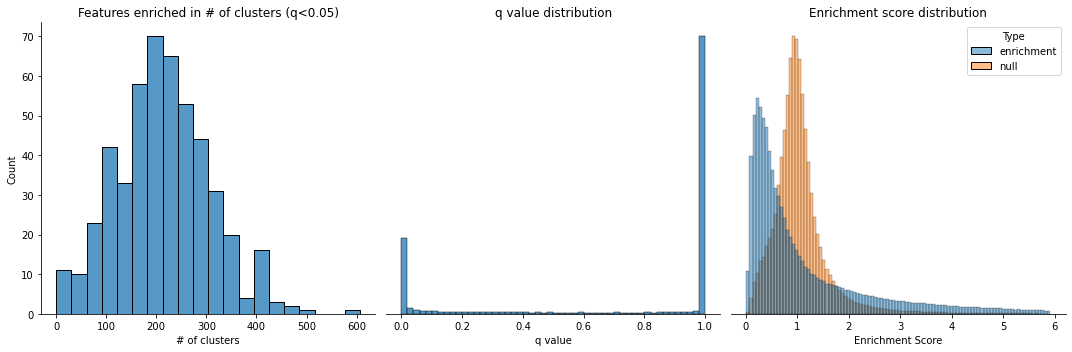

In [14]:
# CEF function take the original mC fraction as input
cluster_enriched_features(adata,
                          cluster_col=cef_cluster_level,
                          top_n=50,
                          alpha=0.05,
                          stat_plot=True,
                          method='mc')

In [15]:
# select CEF only
cef = adata.var[f'{cef_cluster_level}_enriched_features'].copy()

# add some global CEF to list
if global_cef is not None:
    global_cef = pd.read_csv(global_cef, header=None, index_col=0).index
    cef.loc[cef.index.isin(global_cef)] = True

cef.to_csv('mC.CEF.csv', header=None)

In [16]:
cef.sum()

448